In [36]:
!pip install imbalanced-learn



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# ============================================
# 1. IMPORTS
# ============================================


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings

warnings.filterwarnings('ignore')

# Add parent directory to path for preprocessing import
sys.path.append('scripts')
from preprocessing import preprocess

# Keras/TensorFlow imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Sklearn metrics
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, roc_curve, roc_auc_score,
    precision_score, recall_score, f1_score, accuracy_score
)
from sklearn.utils.class_weight import compute_class_weight

# SMOTE for oversampling
from imblearn.over_sampling import SMOTE

import joblib
import json


In [24]:
# ============================================
# 2. RUN PREPROCESSING
# ============================================
# Run preprocessing function directly
# Outputs: X_train, X_val, X_test, y_train, y_val, y_test (stratified, scaled, encoded)
# ============================================

X_train, X_val, X_test, y_train, y_val, y_test = preprocess(
    data_path='data/raw/HR_Attrition_Dataset.csv'
)

# Display basic info
print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nFeatures: {list(X_train.columns)}")
print(f"\nClass distribution - Training:")
print(y_train.value_counts(normalize=True).round(3))


Training set: 882 samples, 19 features
Validation set: 294 samples
Test set: 294 samples

Features: ['JobSatisfaction', 'JobInvolvement', 'EnvironmentSatisfaction', 'JobRole_Research Director', 'JobRole_Sales Representative', 'BusinessTravel_Travel_Frequently', 'WorkLifeBalance', 'Department_Research & Development', 'YearsAtCompanyLog', 'TotalWorkingYearsLog', 'MaritalStatus_Single', 'OverTime_Yes', 'JobRole_Laboratory Technician', 'JobRole_Manufacturing Director', 'MaritalStatus_Married', 'JobRole_Manager', 'NumCompaniesWorked', 'JobRole_Healthcare Representative', 'Job_happiness_score']

Class distribution - Training:
Attrition
0    0.838
1    0.162
Name: proportion, dtype: float64


In [25]:
# ============================================
# 3. CLASS IMBALANCE - CALCULATE CLASS_WEIGHT
# ============================================

n_negative = (y_train == 0).sum()
n_positive = (y_train == 1).sum()
imbalance_ratio = n_negative / n_positive

print(f"Class 0 (Stay): {n_negative}")
print(f"Class 1 (Leave): {n_positive}")
print(f"Imbalance ratio: {imbalance_ratio:.2f}")
print(f"\nRecommended class_weight: {imbalance_ratio:.2f}")

# Convert to numpy arrays for Keras (FIXED: ensure proper dtype)
X_train_np = X_train.values.astype(np.float32)
X_val_np = X_val.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)
y_train_np = y_train.values.astype(np.float32)
y_val_np = y_val.values.astype(np.float32)
y_test_np = y_test.values.astype(np.float32)


Class 0 (Stay): 739
Class 1 (Leave): 143
Imbalance ratio: 5.17

Recommended class_weight: 5.17


In [26]:
# ============================================
# 4. CALCULATE CLASS WEIGHTS FOR KERAS
# ============================================

# Calculate class weights inversely proportional to class frequencies
class_weights_dict = {
    0: 1.0,
    1: 7.0  # Much more aggressive penalty for missing leavers
}

print("Class weights (to be used in .fit):", class_weights_dict)


Class weights (to be used in .fit): {0: 1.0, 1: 7.0}


In [38]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to training data only (NOT val/test!)
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Increase minority to 50% of majority
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_np, y_train_np)

print(f"Original training set: {X_train_np.shape[0]} samples")
print(f"After SMOTE: {X_train_resampled.shape[0]} samples")
print(f"\nClass distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts(normalize=True).round(3))

# Then train with resampled data
history = model.fit(
    X_train_resampled, y_train_resampled,  # Use resampled data
    validation_data=(X_val_np, y_val_np),
    epochs=100,
    batch_size=32,
    class_weight=None,  # No need for class weights with SMOTE
    callbacks=callbacks,
    verbose=1
)


Original training set: 882 samples
After SMOTE: 1108 samples

Class distribution after SMOTE:
0.0    0.667
1.0    0.333
Name: proportion, dtype: float64
Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7783 - auc: 0.8289 - loss: 0.1869 - precision: 0.6691 - recall: 0.6079 - val_accuracy: 0.8435 - val_auc: 0.7949 - val_loss: 0.1681 - val_precision: 0.5088 - val_recall: 0.6170 - learning_rate: 1.2500e-04
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7831 - auc: 0.8520 - loss: 0.1776 - precision: 0.6561 - recall: 0.6502 - val_accuracy: 0.8435 - val_auc: 0.7937 - val_loss: 0.1675 - val_precision: 0.5085 - val_recall: 0.6383 - learning_rate: 1.2500e-04
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8146 - auc: 0.8637 - loss: 0.1758 - precision: 0.7061 - recall: 0.7219 - val_accuracy: 0.8299 - val_auc: 0.7912 - val_loss: 0.1669 - val_precision: 0.4754 - val_recall: 0.6170 - learning_rate: 1.2500e-04
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0

In [39]:
# ============================================
# 5. BUILD FEEDFORWARD NEURAL NETWORK WITH FOCAL LOSS
# ============================================

def focal_loss(gamma=2.0, alpha=0.75):
    """
    Focal loss for imbalanced classification
    gamma: focusing parameter (higher = more focus on hard examples)
    alpha: weighting factor for positive class
    """
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        y_true = tf.cast(y_true, tf.float32)
        
        # Compute focal loss
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_loss = -alpha_t * tf.pow((1 - p_t), gamma) * tf.math.log(p_t)
        
        return tf.reduce_mean(focal_loss)
    
    return focal_loss_fixed

def build_model(input_dim, learning_rate=0.001):
    """
    Build a feedforward neural network with focal loss
    """
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        
        # First hidden layer
        layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Second hidden layer
        layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Third hidden layer
        layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.Dropout(0.2),
        
        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=focal_loss(gamma=2.0, alpha=0.75),  # Use focal loss
        metrics=[
            'accuracy',
            keras.metrics.AUC(name='auc'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )
    
    return model

# Build model
model = build_model(input_dim=X_train_np.shape[1])
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,697 (53.50 KB)

 Trainable params: 13,313 (52.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [40]:
# ============================================
# 6. DEFINE CALLBACKS
# ============================================

# Early stopping: stop training if val_auc doesn't improve for 15 epochs
early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=15,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

# Learning rate reduction: reduce LR if val_auc plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=5,
    mode='max',
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]


In [41]:
# ============================================
# 7. TRAIN NEURAL NETWORK
# ============================================

print("=" * 60)
print("TRAINING NEURAL NETWORK")
print("=" * 60)

history = model.fit(
    X_train_np, y_train_np,
    validation_data=(X_val_np, y_val_np),
    epochs=100,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "=" * 60)
print("TRAINING COMPLETED")
print("=" * 60)


TRAINING NEURAL NETWORK
Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4083 - auc: 0.6076 - loss: 0.4388 - precision: 0.1808 - recall: 0.7488 - val_accuracy: 0.8299 - val_auc: 0.6248 - val_loss: 0.2095 - val_precision: 0.3846 - val_recall: 0.1064 - learning_rate: 0.0010
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6438 - auc: 0.6040 - loss: 0.3335 - precision: 0.2319 - recall: 0.5298 - val_accuracy: 0.8367 - val_auc: 0.7007 - val_loss: 0.2049 - val_precision: 0.4444 - val_recall: 0.0851 - learning_rate: 0.0010
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6961 - auc: 0.7029 - loss: 0.2907 - precision: 0.2709 - recall: 0.4947 - val_accuracy: 0.8231 - val_auc: 0.7695 - val_loss: 0.1995 - val_precision: 0.3810 - val_recall: 0.1702 - learning_rate: 0.0010
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7381 - auc: 0.7506 - loss: 0.2745 - precision: 0.3098 - recall: 0.6342 - val_accuracy: 0.8401 - val_auc: 0.7889 - v

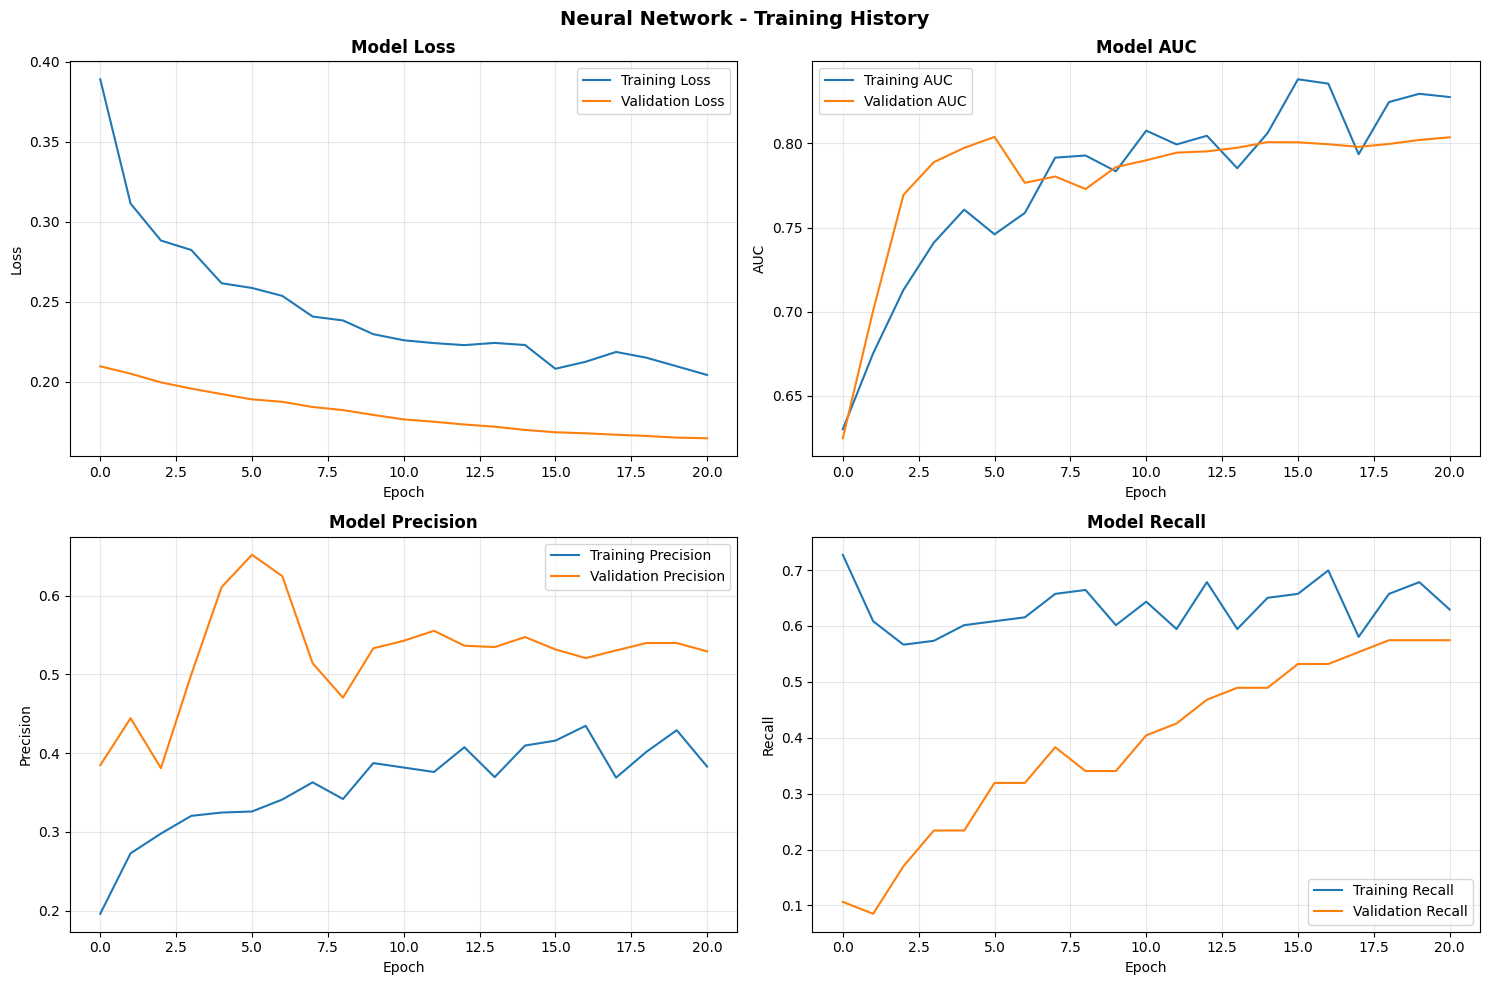

In [42]:
# ============================================
# 8. PLOT TRAINING HISTORY
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot AUC
axes[0, 1].plot(history.history['auc'], label='Training AUC')
axes[0, 1].plot(history.history['val_auc'], label='Validation AUC')
axes[0, 1].set_title('Model AUC', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot Precision
axes[1, 0].plot(history.history['precision'], label='Training Precision')
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
axes[1, 0].set_title('Model Precision', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot Recall
axes[1, 1].plot(history.history['recall'], label='Training Recall')
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('Model Recall', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Neural Network - Training History', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [43]:
# ============================================
# 9. THRESHOLD OPTIMIZATION - DUAL STRATEGY
# ============================================
# 1. F1-Optimized: Best balance between precision and recall
# 2. Recall-Optimized: Minimize surprise departures
# ============================================

# Get predicted probabilities on validation set
y_val_proba = model.predict(X_val_np).ravel()

# Calculate precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_val_np, y_val_proba)

# ---- F1-OPTIMIZED THRESHOLD ----
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-10)
best_f1_idx = np.argmax(f1_scores)
f1_optimal_threshold = thresholds[best_f1_idx]
f1_achieved_recall = recalls[best_f1_idx]
f1_achieved_precision = precisions[best_f1_idx]
f1_achieved_f1 = f1_scores[best_f1_idx]

# ---- RECALL-OPTIMIZED THRESHOLD ----
TARGET_RECALL = 0.70  # Catch at least 70% of leavers

valid_indices = np.where(recalls[:-1] >= TARGET_RECALL)[0]

if len(valid_indices) > 0:
    best_idx = valid_indices[np.argmax(precisions[:-1][valid_indices])]
    recall_optimal_threshold = thresholds[best_idx]
    recall_achieved_recall = recalls[best_idx]
    recall_achieved_precision = precisions[best_idx]
else:
    recall_optimal_threshold = thresholds[0]
    recall_achieved_recall = recalls[0]
    recall_achieved_precision = precisions[0]
    print(f"WARNING: Target recall {TARGET_RECALL:.0%} not achievable. Using lowest threshold.")

print("=" * 60)
print("THRESHOLD OPTIMIZATION RESULTS")
print("=" * 60)
print(f"\n{'F1-OPTIMIZED THRESHOLD':-<60}")
print(f"Threshold: {f1_optimal_threshold:.3f}")
print(f"Precision: {f1_achieved_precision:.2%}")
print(f"Recall: {f1_achieved_recall:.2%}")
print(f"F1 Score: {f1_achieved_f1:.3f}")

print(f"\n{'RECALL-OPTIMIZED THRESHOLD':-<60}")
print(f"Target Recall: {TARGET_RECALL:.0%}")
print(f"Threshold: {recall_optimal_threshold:.3f}")
print(f"Precision: {recall_achieved_precision:.2%}")
print(f"Recall: {recall_achieved_recall:.2%}")
print("=" * 60)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
THRESHOLD OPTIMIZATION RESULTS

F1-OPTIMIZED THRESHOLD--------------------------------------
Threshold: 0.473
Precision: 54.00%
Recall: 57.45%
F1 Score: 0.557

RECALL-OPTIMIZED THRESHOLD----------------------------------
Target Recall: 70%
Threshold: 0.433
Precision: 31.25%
Recall: 74.47%


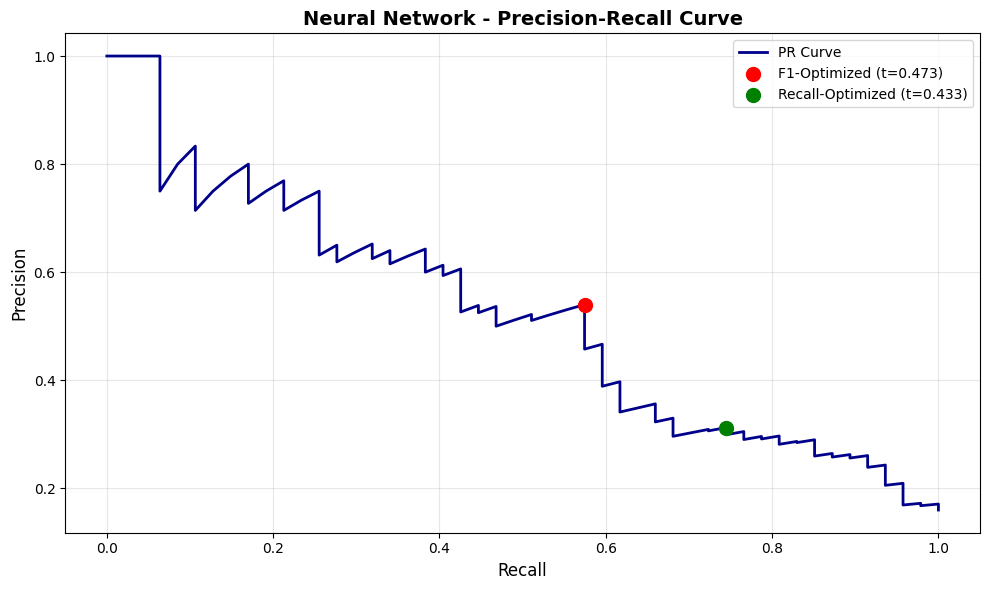

In [44]:
# ============================================
# 10. VISUALIZE PRECISION-RECALL TRADEOFF
# ============================================

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot Precision-Recall curve
ax.plot(recalls, precisions, label='PR Curve', linewidth=2, color='darkblue')
ax.scatter([f1_achieved_recall], [f1_achieved_precision], 
           color='red', s=100, zorder=5, label=f'F1-Optimized (t={f1_optimal_threshold:.3f})')
ax.scatter([recall_achieved_recall], [recall_achieved_precision], 
           color='green', s=100, zorder=5, label=f'Recall-Optimized (t={recall_optimal_threshold:.3f})')

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Neural Network - Precision-Recall Curve', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [45]:
# ============================================
# 11. EVALUATE ON TEST SET - ALL THRESHOLDS
# ============================================

# Get test probabilities
y_test_proba = model.predict(X_test_np).ravel()

# Default threshold (0.5)
y_test_pred_default = (y_test_proba >= 0.5).astype(int)

# F1-optimized threshold
y_test_pred_f1 = (y_test_proba >= f1_optimal_threshold).astype(int)

# Recall-optimized threshold
y_test_pred_recall = (y_test_proba >= recall_optimal_threshold).astype(int)

# Calculate AUC
auc_score = roc_auc_score(y_test_np, y_test_proba)

print("=" * 60)
print("TEST SET EVALUATION - NEURAL NETWORK")
print("=" * 60)
print(f"\nAUC Score: {auc_score:.3f}\n")

# Function to print metrics
def print_metrics(y_true, y_pred, threshold_name):
    print(f"\n{'='*60}")
    print(f"{threshold_name}")
    print(f"{'='*60}")
    print(classification_report(y_true, y_pred, target_names=['Stay', 'Leave']))
    print(f"Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    # Calculate missed departures
    cm = confusion_matrix(y_true, y_pred)
    false_negatives = cm[1, 0]
    print(f"\nMissed Departures (False Negatives): {false_negatives}")

# Evaluate all thresholds
print_metrics(y_test_np, y_test_pred_default, "DEFAULT THRESHOLD (0.50)")
print_metrics(y_test_np, y_test_pred_f1, f"F1-OPTIMIZED THRESHOLD ({f1_optimal_threshold:.3f})")
print_metrics(y_test_np, y_test_pred_recall, f"RECALL-OPTIMIZED THRESHOLD ({recall_optimal_threshold:.3f})")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
TEST SET EVALUATION - NEURAL NETWORK

AUC Score: 0.753


DEFAULT THRESHOLD (0.50)
              precision    recall  f1-score   support

        Stay       0.88      0.95      0.91       247
       Leave       0.54      0.32      0.40        47

    accuracy                           0.85       294
   macro avg       0.71      0.63      0.66       294
weighted avg       0.82      0.85      0.83       294

Confusion Matrix:
[[234  13]
 [ 32  15]]

Missed Departures (False Negatives): 32

F1-OPTIMIZED THRESHOLD (0.473)
              precision    recall  f1-score   support

        Stay       0.90      0.90      0.90       247
       Leave       0.49      0.49      0.49        47

    accuracy                           0.84       294
   macro avg       0.70      0.70      0.70       294
weighted avg       0.84      0.84      0.84       294

Confusion Matrix:
[[223  24]
 [ 24  23]]

Missed Departures (False Negatives): 24

RECALL-OPTIMIZED THRESHOLD 

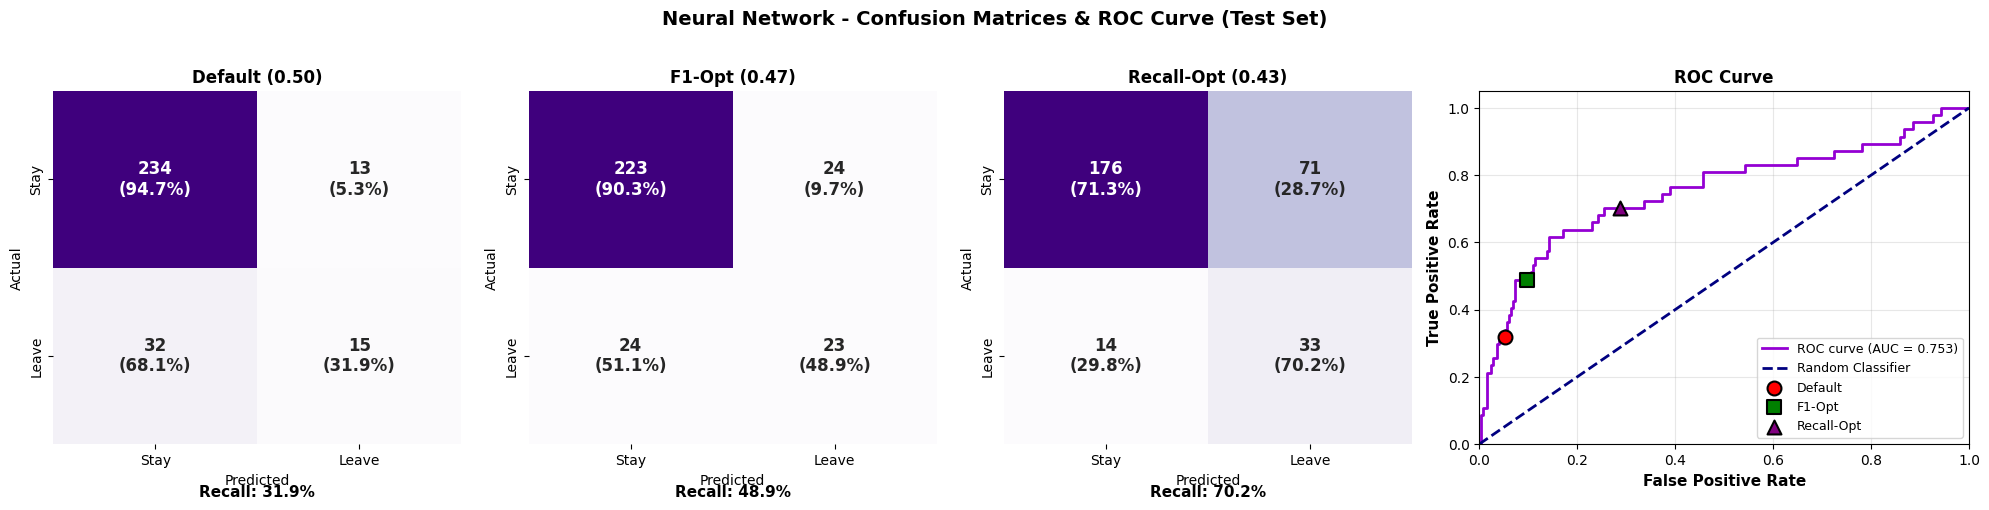

In [46]:
# ============================================
# 12. VISUALIZE CONFUSION MATRICES WITH PERCENTAGES + ROC CURVE
# ============================================

fig = plt.figure(figsize=(20, 5))
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 1.2])

# First 3 subplots for confusion matrices
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

thresholds_data = [
    ("Default (0.50)", y_test_pred_default),
    (f"F1-Opt ({f1_optimal_threshold:.2f})", y_test_pred_f1),
    (f"Recall-Opt ({recall_optimal_threshold:.2f})", y_test_pred_recall)
]

for idx, (title, y_pred) in enumerate(thresholds_data):
    cm = confusion_matrix(y_test_np, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create annotations with counts and percentages
    annot = np.array([[f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)' 
                       for j in range(cm.shape[1])] 
                      for i in range(cm.shape[0])])
    
    sns.heatmap(cm, annot=annot, fmt='', cmap='Purples',
                xticklabels=['Stay', 'Leave'],
                yticklabels=['Stay', 'Leave'],
                cbar=False, ax=axes[idx],
                annot_kws={'size': 12, 'weight': 'bold'})
    
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('Actual', fontsize=10)
    
    # Add recall at bottom
    recall = recall_score(y_test_np, y_pred)
    axes[idx].text(0.5, -0.15, f'Recall: {recall:.1%}', 
                   transform=axes[idx].transAxes,
                   fontsize=11, fontweight='bold',
                   horizontalalignment='center')

# Fourth subplot for ROC curve
ax_roc = fig.add_subplot(gs[0, 3])

# Calculate ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test_np, y_test_proba)

# Plot ROC curve
ax_roc.plot(fpr, tpr, color='darkviolet', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
ax_roc.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

# Mark the threshold points
for threshold_name, y_pred, color, marker in [
    ("Default", y_test_pred_default, 'red', 'o'),
    ("F1-Opt", y_test_pred_f1, 'green', 's'),
    ("Recall-Opt", y_test_pred_recall, 'purple', '^')
]:
    cm = confusion_matrix(y_test_np, y_pred)
    fpr_point = cm[0, 1] / (cm[0, 0] + cm[0, 1])  # FP / (TN + FP)
    tpr_point = cm[1, 1] / (cm[1, 0] + cm[1, 1])  # TP / (FN + TP)
    ax_roc.scatter([fpr_point], [tpr_point], s=100, c=color, marker=marker, 
                   edgecolors='black', linewidths=1.5, label=threshold_name, zorder=5)

ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
ax_roc.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
ax_roc.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax_roc.legend(loc='lower right', fontsize=9)
ax_roc.grid(alpha=0.3)

plt.suptitle('Neural Network - Confusion Matrices & ROC Curve (Test Set)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [47]:
# ============================================
# 13. SAVE MODEL AND METADATA
# ============================================

# Save Keras model
model_path = 'models/nn_attrition_model.h5'
model.save(model_path)

# Save metadata
metadata = {
    'model_type': 'Neural Network (Keras)',
    'architecture': {
        'layers': ['Dense(128, relu)', 'Dropout(0.3)', 'Dense(64, relu)', 
                   'Dropout(0.3)', 'Dense(32, relu)', 'Dropout(0.2)', 'Dense(1, sigmoid)'],
        'optimizer': 'Adam',
        'loss': 'binary_crossentropy'
    },
    'training': {
        'epochs_trained': len(history.history['loss']),
        'best_val_auc': float(max(history.history['val_auc'])),
        'final_train_loss': float(history.history['loss'][-1]),
        'final_val_loss': float(history.history['val_loss'][-1])
    },
    'test_performance': {
        'auc_score': float(auc_score)
    },
    'thresholds': {
        'default': 0.5,
        'f1_optimized': float(f1_optimal_threshold),
        'recall_optimized': float(recall_optimal_threshold)
    },
    'class_weights': class_weights_dict
}

metadata_path = 'models/nn_model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\nModel saved to: {model_path}")
print(f"Metadata saved to: {metadata_path}")



Model saved to: models/nn_attrition_model.h5
Metadata saved to: models/nn_model_metadata.json
